# Import packages

In [7]:
import numpy as np
import pylab as pl
from numpy import fft
# Chart modules
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()


from kucoin.client import Market
import pandas as pd
import numpy as np
from datetime import datetime
import time
import math
client = Market(url='https://api.kucoin.com')


from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression

Loading BokehJS ...

In [8]:
def fourierExtrapolation(x, n_predict, has_trend=True):
    n = x.size
    n_harm = 50                     # number of harmonics in model
    t = np.arange(0, n)
    if has_trend==True:
        p = np.polyfit(t, x, 1)         # find linear trend in x
        x_notrend = x - p[0] * t        # detrended x
        x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
        f = fft.fftfreq(n)              # frequencies
        indexes = list(range(n))
        #indexes = range(n)
        # sort indexes by frequency, lower -> higher
        indexes.sort(key = lambda i: np.absolute(f[i]))
    
        t = np.arange(0, n + n_predict)
        restored_sig = np.zeros(t.size)
        for i in indexes[:1 + n_harm * 2]:
            ampli = np.absolute(x_freqdom[i]) / n   # amplitude
            phase = np.angle(x_freqdom[i])          # phase
            restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
        return restored_sig + p[0] * t   
    else:
        x_notrend = x      # detrended x
        x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
        f = fft.fftfreq(n)              # frequencies
        indexes = list(range(n))
        #indexes = range(n)
        # sort indexes by frequency, lower -> higher
        indexes.sort(key = lambda i: np.absolute(f[i]))
    
        t = np.arange(0, n + n_predict)
        restored_sig = np.zeros(t.size)
        for i in indexes[:1 + n_harm * 2]:
            ampli = np.absolute(x_freqdom[i]) / n   # amplitude
            phase = np.angle(x_freqdom[i])          # phase
            restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
        return restored_sig


def getLastestData(symbol="BTC",timeframe='15min')-> pd.DataFrame:
    """Function that uses Kucoin API to get the latest data for a specific symbol and timeframe.

    Args:
        symbol (str, optional): The symbol for the data we want to extract. Defaults to "BTC".
        indicators (bool, optional): Whether we want to add indicators to the dataframe or not. Defaults to False.

    Returns:
        pd.DataFrame: The dataframe containing history.
    """
    klines = client.get_kline(f'{symbol}-USDT',timeframe, startAt=round(datetime.now().timestamp())-1950000, endAt=round(datetime.now().timestamp()))
    df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
    df = df.sort_values(by='Date')
    df['Timestamp'] = df['Date'].astype(int)
    df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
    df = df.set_index('Date')
    return df


In [10]:
symbol = 'SOL'
df = getLastestData(symbol,'5min',)
pred_count = 100
train_data = df.Close[:-pred_count]
test_data = df.Close[-pred_count:]
x = np.array(train_data)
n_predict = pred_count
extrapolation = fourierExtrapolation(x, n_predict)

p = figure(title=f"Prediction on {symbol} from BTC", x_axis_label='Time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
    #("Date", "$x{%F}"),
], formatters={
        '$x': 'printf',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(np.arange(0, x.size), x, legend_label="Train data", line_width=2,)
p.line(np.arange(0, extrapolation.size), extrapolation,legend_label="Extrapolation", line_width=2, color='orange')
p.line(np.arange(x.size, extrapolation.size), test_data,legend_label="Test data", line_width=2, color='black')
p.legend.location = "top_left"

show(p)

# MLR coef indicator extrapolation

/tmp/ipykernel_48403/1863682042.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['B_MLR_coefs'].iloc[window:] = coefs_2
/tmp/ipykernel_48403/1863682042.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['B_MLR_coefs_filtered_MIN_MAX'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]


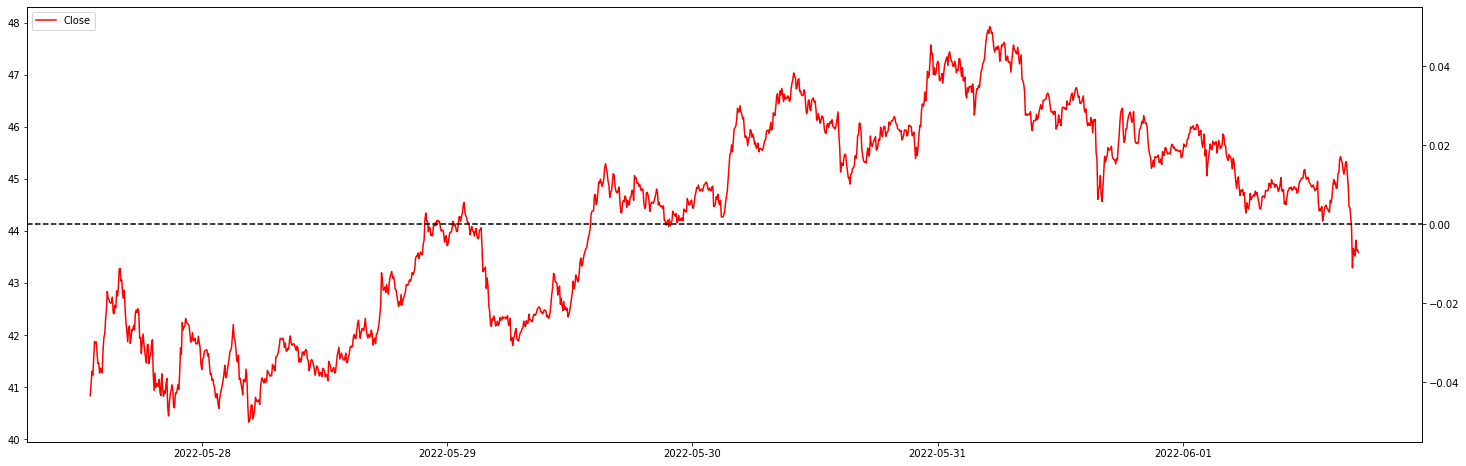

In [4]:

coefs_2 = []

window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs_2.append(model.coef_[0])

df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs_2

df.dropna(inplace=True)
df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, 20, 2,mode='wrap',deriv=0)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
df.dropna(inplace=True)
df['B_MLR_coefs_filtered_MIN_MAX'] = np.nan
df['B_MLR_coefs_filtered_MIN_MAX'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
df.dropna(inplace=True)
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df.Close, color='red',label='Close')
ax_right = ax_left.twinx()
ax_right.scatter(df[df['B_MLR_coefs_filtered']>0.02].index, df[df['B_MLR_coefs_filtered']>0.02]['B_MLR_coefs_filtered'], color='blue',label='F MLR coefs filtered SELL')
ax_right.scatter(df[df['B_MLR_coefs_filtered']<-0.02].index, df[df['B_MLR_coefs_filtered']<-0.02]['B_MLR_coefs_filtered'], color='yellow',label='F MLR coefs filtered BUY')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left.legend(loc="upper left")

In [5]:

n_predict = 100
train_data = df['B_MLR_coefs_filtered'][:-n_predict]
test_data = df['B_MLR_coefs_filtered'][-n_predict:]
x = np.array(train_data)
extrapolation = fourierExtrapolation(x, n_predict,False)

p = figure(title=f"Prediction on {symbol} from BTC", x_axis_label='Time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
    #("Date", "$x{%F}"),
], formatters={
        '$x': 'printf',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(np.arange(0, x.size), x, legend_label="real data", line_width=2,)
p.line(np.arange(0, extrapolation.size), extrapolation,legend_label="Extrapolation", line_width=2, color='orange')
p.line(np.arange(x.size, extrapolation.size), test_data,legend_label="Test data", line_width=2, color='black')
p.legend.location = "top_left"

show(p)